In [1]:
%reload_ext autoreload
%autoreload 2
from copy import deepcopy
import numpy as np
import torch
from torch.autograd.functional import jacobian
from systems.base import functions
from systems.multirotor import Multirotor, VP, SP
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange

fp = functions(use_torch=True)

In [3]:
from systems.base import functions
from scripts.opt_pidcontroller import (
    get_study as get_study_pid, apply_params as apply_params_pid, run_sim,
    get_controller, apply_fault, make_disturbance_fn
)
from scripts.opt_multirotorenv import apply_params, get_study
from systems.multirotor import VP, SP, MultirotorTrajEnv, Multirotor, run_sim, run_trajectory
from multirotor.trajectories import Trajectory, eight_curve
from multirotor.helpers import DataLog, control_allocation_matrix
from multirotor.visualize import plot_datalog, get_wind_quiver, make_drawing
from systems.multirotor import VP, SP

ns = functions(use_torch=True)

# speeds -> dynamics
def f_t(speeds: torch.Tensor, vp=VP):
    """Forces/torques acting on body given allocated speeds"""
    thrust = torch.zeros(3, len(vp.propellers))
    k_th = torch.tensor([p.k_thrust for p in vp.propellers])
    thrust[2,:] = k_th * speeds**2
    
    torque = torch.zeros(3, len(vp.propellers))
    k_d = torch.tensor([p.k_drag for p in vp.propellers]).float()
    clockwise = torch.tensor(vp.clockwise).float()
    positions = torch.tensor(vp.propeller_vectors).float()
    tau_xy = torch.linalg.cross(positions.T, thrust.T).T
    tau_z = clockwise * k_d * speeds**2
    torque[:2,:] = tau_xy[:2, :]
    torque[2, :] = tau_z
    return thrust.sum(axis=1), torque.sum(axis=1)


# dynamics -> state change
def dxdt(
    forces: np.ndarray, torques: np.ndarray, x: np.ndarray,
    g: float=SP.g, mass=VP.mass,
    inertia_matrix=torch.from_numpy(VP.inertia_matrix).float(),
    inertia_matrix_inverse=torch.from_numpy(VP.inertia_matrix_inverse).float(),
    np=ns,
) -> torch.Tensor:
    """Rate of change of state given forces/torques acting on body"""
    
    # Store state variables in a readable format
    xI = x[0]       # Inertial frame positions
    yI = x[1]
    zI = x[2]
    ub = x[3]       # linear velocity along body-frame-x-axis b1
    vb = x[4]       # linear velocity along body-frame-y-axis b2
    wb = x[5]       # linear velocity along body-frame-z-axis b3
    phi = x[6]      # Roll
    theta = x[7]    # Pitch
    psi = x[8]      # Yaw
    p = x[9]        # body-frame-x-axis rotation rate
    q = x[10]       # body-frame-y-axis rotation rate
    r = x[11]       # body-frame-z-axis rotation rate
    
    cphi = np.cos(phi);   sphi = np.sin(phi)    # roll
    cthe = np.cos(theta); sthe = np.sin(theta)  # pitch
    cpsi = np.cos(psi);   spsi = np.sin(psi)    # yaw
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros(12, dtype=x.dtype)

    xdot[0] = cthe*cpsi*ub + (-cphi * spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xIdot 
    xdot[1] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yIdot 
    xdot[2] = (-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = zIdot

    xdot[3] = 1/mass * (forces[0])     + g * sthe          + r * vb - q * wb  # = udot
    xdot[4] = 1/mass * (forces[1])     - g * sphi * cthe   - r * ub + p * wb # = vdot
    xdot[5] = 1/mass * (forces[2])     - g * cphi * cthe   + q * ub - p * vb # = wdot

    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot

    gyro = np.cross(x[9:12], inertia_matrix @ x[9:12])
    xdot[9:12] = inertia_matrix_inverse @ (torques - gyro)
    
    return xdot

def dxdt_u(speeds: torch.Tensor, x: torch.Tensor, vp=VP, sp=SP,
           F_P=torch.eye(12), disturb_forces: torch.Tensor=torch.zeros(3)):
    """Rate of change of state given propeller speeds."""
    # speeds = torch.clamp_max(speeds, 700)
    f, t = f_t(speeds=speeds, vp=vp)
    dx = F_P @ dxdt(
        forces=f+disturb_forces, torques=t, x=x,
        g=sp.g, mass=vp.mass,
        inertia_matrix=torch.from_numpy(vp.inertia_matrix).float(),
        inertia_matrix_inverse=torch.from_numpy(vp.inertia_matrix_inverse).float(),
        np=ns,
    )
    return dx

def dxdt_du(speeds: np.ndarray, x: np.ndarray, vp=VP, sp=SP,
            F_P=torch.eye(12), disturb_forces: torch.Tensor=torch.zeros(3),
            dxdt_u=dxdt_u
           ):
    speeds = torch.as_tensor(speeds).float()
    x = torch.as_tensor(x).float()
    speeds.requires_grad_(True)
    d_du = jacobian(
        func=lambda u: dxdt_u(speeds=u, x=x, vp=vp, sp=sp, F_P=F_P, disturb_forces=disturb_forces),
        inputs=speeds
    )
    return d_du


In [4]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from filterpy.common import Q_discrete_white_noise

class UAVEKF(EKF):
    @classmethod
    def HJacobian_at(cls, x):
        return np.eye(12, dtype=np.float32)
    @classmethod
    def hx(cls, x):
        return x
    
    def __init__(self, interval, P0=None, Q_pos=1, Q_ang=1, R=None):
        super().__init__(dim_x=12, dim_z=12, dim_u=8)
        self.interval = interval
        # vehicle model
        self.sp = deepcopy(SP)
        self.sp.dt *= interval
        self.dt = self.sp.dt
        self.vehicle = Multirotor(VP, self.sp)
        self.x = self.vehicle.state
        # covariance of motion noise in control space
        self.M = np.eye(8) * 0.1
        # State variance
        if P0 is not None:
            self.P = P0
        # Process covariance
        Q_pos = Q_discrete_white_noise(2, block_size=3, dt=interval*SP.dt, var=Q_pos, order_by_dim=False)
        Q_ang = Q_discrete_white_noise(2, block_size=3, dt=interval*SP.dt, var=Q_ang, order_by_dim=False)
        self.Q = np.zeros((12,12))
        self.Q[:6,:6] = Q_pos
        self.Q[6:,6:] = Q_ang
        # Measurement noise
        if R is not None:
            self.R = R

    @property
    def state(self):
        return self.x.copy()
    @state.setter
    def state(self, s):
        self.x = self.x_prior = np.asarray(s, self.x.dtype)
        self.vehicle.state = self.x

    def predict(self, u):
        # update state prediction
        self.x = self.x_prior = self.vehicle.step_speeds(u=u)

        u = fp.asarray(u).float()
        x = fp.asarray(self.x).float()
        # evaluate F, V at current x,u
        # F = df/dx
        F = jacobian(
            func=lambda x: x + dxdt_u(speeds=u, x=x, vp=VP, sp=self.sp) * self.dt,
            inputs=x
        )
        V = jacobian(
            func=lambda u: x + dxdt_u(speeds=u, x=x, vp=VP, sp=self.sp) * self.dt,
            inputs=u
        )
        self.F, self.V = np.asarray(F), np.asarray(V)

        # update state variance
        self.P = self.F @ self.P @ self.F.T + self.V @ self.M @ self.V.T
    
    def residual(self, a, b):
        y = a - b
        y[6:] = y[6:] % (2 * np.pi)
        y[6:][y[1] > np.pi] -= 2 * np.pi
        return y

  0%|          | 0/1000 [00:00<?, ?it/s]

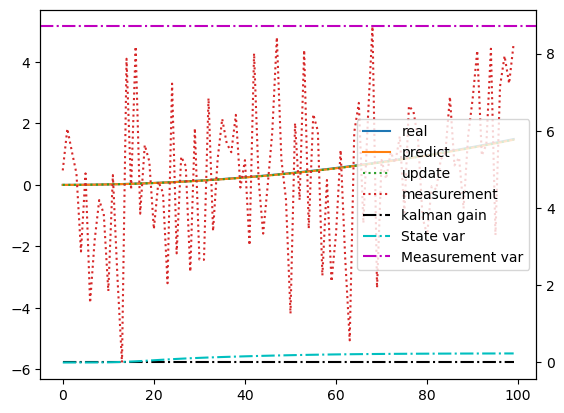

In [9]:
x0 = np.zeros(12, np.float32)
# Measurement noise
R = np.diag([5,5,5,0.5,0.5,0.5,0.01,0.01,0.01,0.01,0.01,0.01])
std_z = np.sqrt(np.diag(R))
# State variance
P = R * 0

duration = 1000 # simulation steps
interval = 10 # EKF interval
m = Multirotor(VP, SP)
m.state = x0

ekf = UAVEKF(interval, P0=P, R=R)
ekf.state = z = x0 + std_z * np.random.randn(12) * 0

u = np.ones(8) * 365

# actual state, x_bar (prediction), x_bar (posterior, updated)
X, Xb, Xh, Z, K, Ps, Rs = [], [], [], [], [], [], []
for i in trange(duration, leave=False):
    
    # simulate
    m.step_speeds(u)
    X.append(m.state.copy())
    
    if i%interval==0:
        Xb.append(ekf.x_prior.copy())
        
        # update
        ekf.update(z, HJacobian=ekf.HJacobian_at, Hx=ekf.hx, 
               residual=ekf.residual)
        Xh.append(ekf.x_post.copy())
        Ps.append(np.linalg.norm(ekf.P))
        K.append(np.linalg.det(ekf.K))
        # predict next state
        ekf.predict(u=u)
        # get measurement
        z = m.state + std_z * np.random.randn(12)
        Z.append(z)

X = np.asarray(X)
Xb = np.asarray(Xb)
Xh = np.asarray(Xh)
Z = np.asarray(Z)

plt.plot(X[::interval,2], label='real')
plt.plot(Xb[:,2], label='predict')
plt.plot(Xh[:,2], label='update', ls=':')
plt.plot(Z[:,2], label='measurement', ls=':')
lines = plt.gca().lines
plt.twinx()
plt.plot(K, label='kalman gain', c='k', ls='-.')
plt.plot(Ps, label='State var', c='c', ls='-.')
plt.axhline(np.linalg.norm(R), label='Measurement var', c='m', ls='-.')
plt.legend(handles=lines+plt.gca().lines)